# Project Name : Customer Buying Behavior 

#### Import Libraries

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing & splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Evaluation metrics
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,
    classification_report,confusion_matrix,auc,roc_auc_score, roc_curve
)

# Regression Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost
from xgboost import XGBClassifier

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Save the model
import joblib

# Load Dataset

In [2]:
data = pd.read_csv('Customer_Behaviour.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
data.duplicated().sum()

0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [5]:
data['Gender'].unique()

array(['Male', 'Female'], dtype=object)

# Check target column value count

In [6]:
data['Purchased'].value_counts()

Purchased
0    257
1    143
Name: count, dtype: int64

# Mapping

In [7]:
data['Gender'] = data['Gender'].map({'Female':0,'Male':1})

# Drop useless column

In [8]:
data.drop(['User ID'],axis=1,inplace=True)

# Heatmap

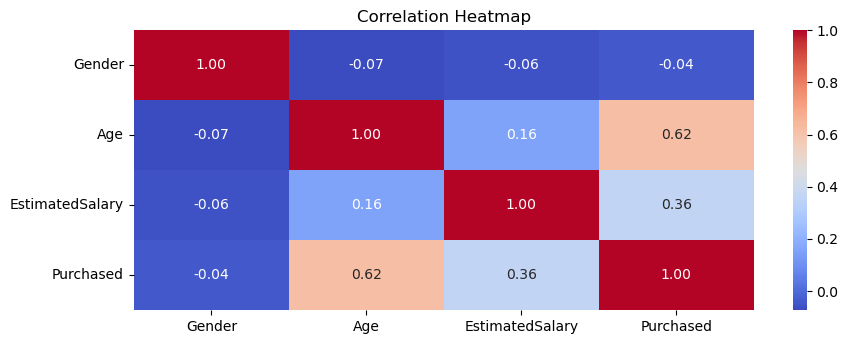

In [9]:
plt.figure(figsize=(34,8))
plt.subplot(2,3,2)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show();

# Feature Relationships with Purchased

<Figure size 1400x800 with 0 Axes>

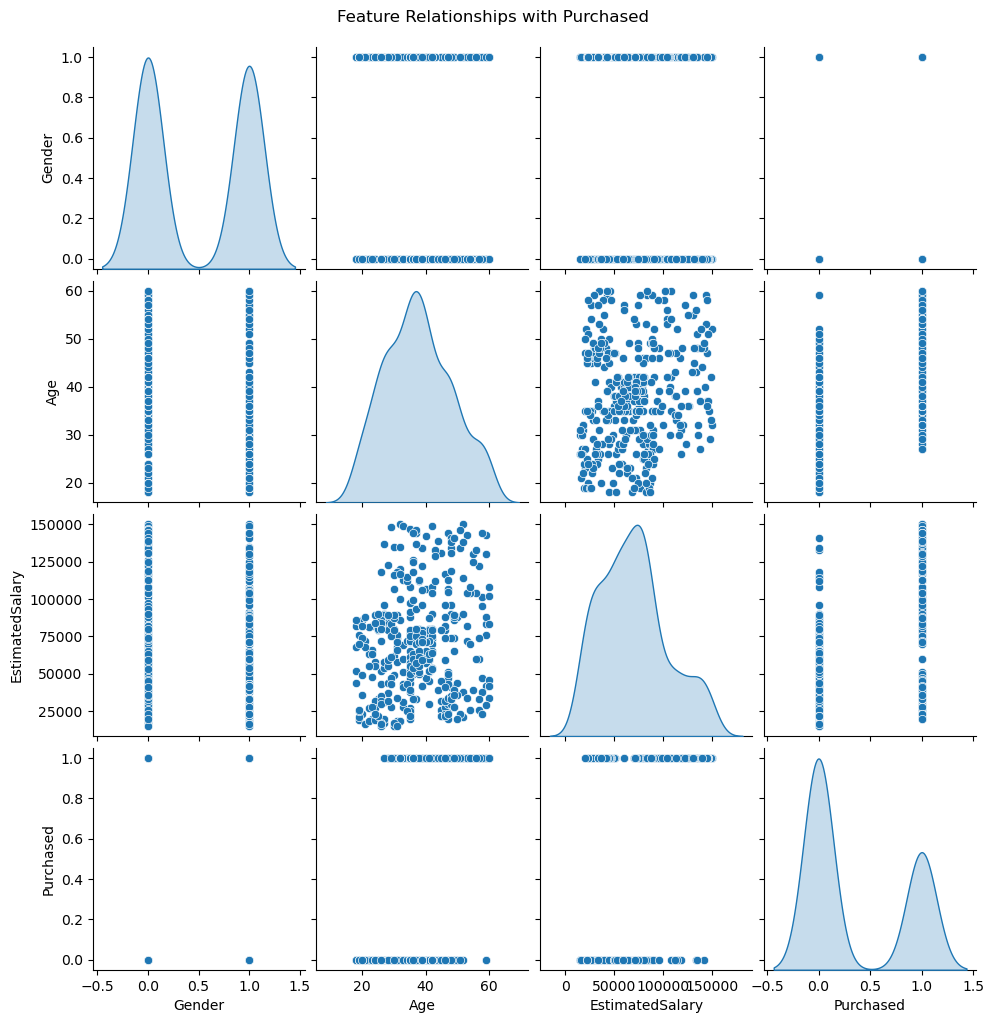

In [12]:
plt.figure(figsize=(14,8))
sns.pairplot(data[['Gender', 'Age', 'EstimatedSalary', 'Purchased']], diag_kind='kde')
plt.suptitle("Feature Relationships with Purchased", y=1.02)
plt.show();

# Splitting for Target into Train Test Split

In [13]:
X = data.drop(['Purchased'],axis=1)
y = data['Purchased']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Preprocessing Pipeline

In [14]:
preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Define models & parameter grids for classification

In [15]:
models = {
    # -------------------------------
    "Logistic Regression": {
        "model": LogisticRegression(solver='lbfgs', max_iter=500, random_state=42),
        "param_grid": {
            "C": [0.1, 1, 10],
            "penalty": ['l2']
        }
    },
    # -------------------------------
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "param_grid": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    # -------------------------------
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    # -------------------------------
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    # -------------------------------
    "Extra Trees": {
        "model": ExtraTreesClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "p": [1, 2]  # Manhattan (L1) or Euclidean (L2)
        }
    },
    # -------------------------------
    "MLP Classifier": {
        "model": MLPClassifier(random_state=42),
        "param_grid": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu", "tanh"],
            "solver": ["adam"],
            "max_iter": [200]
        }
    },
    # -------------------------------
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    }
}

print(f" Total Models Loaded: {len(models)}")

 Total Models Loaded: 9


# Model Evaluation Run GridSearchCV for each classification

In [16]:
results = []
best_score = -float('inf')
best_model = None
best_name = None

# Run GridSearchCV for each classification model
for name, mp in models.items():
    print(f"\n Running GridSearchCV for {name}...")
    grid = GridSearchCV(mp['model'], param_grid=mp['param_grid'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

    print(f"{name} Best CV Score (Accuracy): {grid.best_score_:.4f}")
    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")


    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

# Output summary
results_df = pd.DataFrame(results)
print("\n Summary Results:")
print(results_df)

print(f"\n Best Model: {best_name}")
print(f" Best CV Score (Accuracy): {best_score:.4f}")


 Running GridSearchCV for Logistic Regression...
Logistic Regression Best CV Score (Accuracy): 0.8594
Logistic Regression Best Params: {'C': 0.1, 'penalty': 'l2'}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        51
           1       0.80      0.69      0.74        29

    accuracy                           0.82        80
   macro avg       0.82      0.80      0.80        80
weighted avg       0.82      0.82      0.82        80


 Running GridSearchCV for Decision Tree...
Decision Tree Best CV Score (Accuracy): 0.9062
Decision Tree Best Params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        51
           1       0.80      0.97      0.88        29

    accuracy                           0.90        80
   macro avg       0.89      

# Confusion Matrix

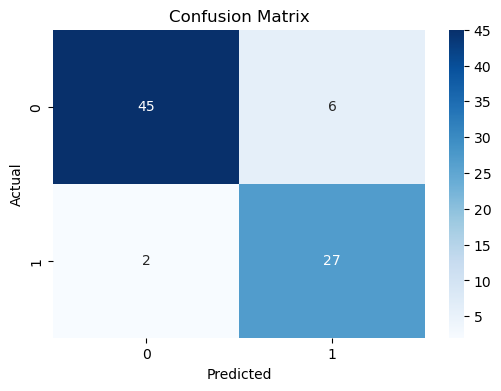

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

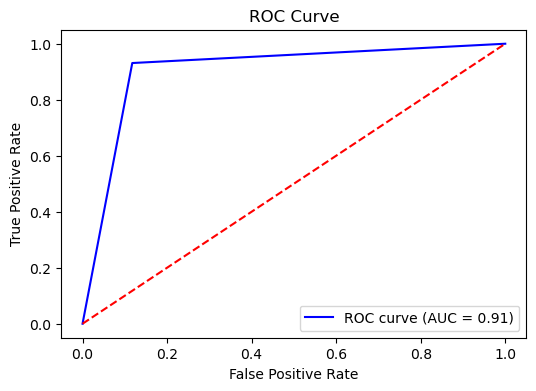

AUC: 0.91


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
print("AUC: %.2f" % roc_auc)

# Save The Model

In [18]:
feature_columns = X.columns.to_list()
joblib.dump(feature_columns,'Customer Buying Prediction.joblib')

['Customer Buying Prediction.joblib']

In [19]:
joblib.dump(best_model,'bestmodel Customer Buying Prediction.joblib')

['bestmodel Customer Buying Prediction.joblib']

# If you have any suggestions, please DM me.
# Even a small message from you can make a big impact on my career
#### I am Arun